In [24]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from math import ceil, floor, log, sqrt
import matplotlib.pyplot as plt
import seaborn as sns
from math import log, ceil, floor
from functools import partial
import pickle

from tqdm import tqdm

alpha = 0.1

def estimate_a_b(p_hat_list):
    m = len(p_hat_list)

    min_p = np.min(p_hat_list)
    max_p = np.max(p_hat_list)
    
    # Bias-corrected estimates of a and b
    a_hat = (m + 1)/m * min_p - (1/m) * max_p
    b_hat = (m + 1)/m * max_p - (1/m) * min_p

    return max([0, a_hat]), min([b_hat, 1])

# Check validity of epsilon
def check_validity_condition(eps, alpha, budget, a_hat=0, b_hat=1, return_val=False):
    b_minus_a = b_hat - a_hat

    if eps > b_minus_a:
        return False
    
    m_star = ceil(abs(log(alpha)) / abs(log(1 - (eps / b_minus_a ) )))
    r_star = budget / m_star
    type_1_error = (1 - (eps - np.sqrt(np.log(r_star) / r_star)) / (b_hat - a_hat))**m_star + 2 * (m_star / np.sqrt(r_star))

    if return_val:
        return type_1_error < alpha, max([0, min([type_1_error, 1])])
    else:
        return type_1_error < alpha


def calculate_size_upper_bound(a,b,m,r,epsilon):
    type_1_error = (1 - (epsilon - np.sqrt(np.log(r) / r)) / (b - a))**m 
    type_1_error += 2 * (m / np.sqrt(r))

    return min([1, min([type_1_error, 1])])


def calculate_power_lower_bound(a,b,m,r,epsilon):
    analytical_power = 2 / ( 1 - (b - a) )
    analytical_power *= ( 1 - ( epsilon + np.sqrt( np.log(r) / r ) ) / (b - a))**m - 1
    analytical_power *= epsilon + np.sqrt(np.log(r) / r)
    analytical_power += 1 - (2*m / np.sqrt(r))

    return max([0, min([analytical_power, 1])])


# Parallel evaluation
def evaluate_epsilon(a_hat, b_hat, eps, alpha, budget, power_type='estimated', n_p_test=1000, n_mc=100, initial_m=100, initial_r=100, size=False):
    m = ceil(abs(log(alpha)) / abs(log(1 - eps)))
    r = floor(budget / m)

    if power_type == 'estimated':
        power_list= []
        for i in range(n_mc):
            p_list = np.random.uniform(a, b, initial_m)
            p_hat_list = [np.random.binomial(initial_r, p) / initial_r  for p in p_list]
            a_hat, b_hat = estimate_a_b(p_hat_list)

            if size:
                power_list.append(calculate_size_upper_bound(a_hat, b_hat, m, r, eps))
            else:
                power_list.append(calculate_power_lower_bound(a_hat, b_hat, m, r, eps))
        power = np.mean(power_list)
    elif power_type == 'analytical':
        if size:
            power = calculate_size_upper_bound(a, b, m, r, eps)
        else:
            power = calculate_lower_bound(a,b,m,r,epsilon)
    elif power_type == 'simulated':
        power = np.mean(simulate_average_power(a,b,m, r,epsilon, n_p_test, n_mc, size))
    out = {'m': m, 'r': r, 'approximate_power': power}
    return out


def get_optimal_test(p_hat_list, epsilon_list, alpha, budget):
    argmax_epsilon = -np.inf
    m_star = -np.inf
    r_star = -np.inf
    max_approximate_power=-10e5

    a_hat, b_hat = estimate_a_b(p_hat_list)
    
    for eps in epsilon_list:
        temp = evaluate_epsilon(a_hat,b_hat, eps, alpha, budget)
        if temp['approximate_power'] > max_approximate_power:
            argmax_epsilon=eps
            m_star=temp['m']
            r_star=temp['r']
            max_approximate_power=temp['approximate_power']

    return {'m': m_star, 'r': r_star, 'epsilon': argmax_epsilon, 'approximate_power': max_approximate_power}


def simulate_test(a,b,m, r, eps, p_test):
    p_list = np.concatenate((np.random.uniform(a, b, m), [p_test]))
    p_hat_list = np.array([np.random.binomial(r, p) / r for p in p_list])
    T_mr = min(abs(p_hat_list[:m] - p_hat_list[m]))
    
    return int(T_mr > eps)


def simulate_power_given_p_test(a, b, m, r, eps, p_test, n_mc=1000):
    results = [simulate_test(a, b, m, r, eps, p_test) for _ in range(n_mc)]
    
    return np.mean(results)


def simulate_average_power(a, b, m, r, eps, n_p_test=100, n_mc=10, size=False):
    p_test_list = np.random.uniform(0, 1, 20*n_p_test)

    if size:
        p_test_list = [p for p in p_test_list if (p > a and p < b)]
    else:
        p_test_list = [p for p in p_test_list if (p < a or p > b)]
    p_test_list = p_test_list[:n_p_test]
    
    power_list = Parallel(n_jobs=-1)(delayed(simulate_power_given_p_test)(a, b, m, r, eps, p_test, n_mc) for p_test in p_test_list)
    
    return power_list


def estimate_average_power_given_budget(alpha, budget, min_epsilon, max_epsilon, epsilon_step, initial_m=25, initial_r=100, n_p_test=100):
    p_list = np.random.uniform(a, b, initial_m)
    p_hat_list = [np.random.binomial(initial_r, p) / initial_r for p in p_list]
    a_hat, b_hat = estimate_a_b(p_hat_list)

    b_minus_a = b_hat - a_hat

    budget -= initial_m * initial_r
    epsilon_list = np.arange(min_epsilon, max_epsilon + epsilon_step, epsilon_step)
    validity_check_list = [check_validity_condition(eps, alpha, budget, a_hat, b_hat) for eps in epsilon_list]
    valid_epsilon_list = [eps for eps, k in zip(epsilon_list, validity_check_list) if k]

    optimal_test = get_optimal_test(p_hat_list, valid_epsilon_list, alpha, budget)

    return estimate_average_power(a, b, optimal_test['epsilon'], optimal_test['m'], optimal_test['r'], n_p_test)

In [18]:
np.random.seed(1)

alpha=0.1

initial_m=25
initial_r=100

min_epsilon=0.005
max_epsilon=0.1
epsilon_step_size = 0.001
epsilon_list = np.arange(min_epsilon, max_epsilon, epsilon_step_size)

n_p_test = 1000
n_mc = 100

budget_list = [10**6, 10**7, 10**8]

size_dict = {}
power_dict = {}

a_b_list = [(0.4, 0.6)]

for (a,b) in a_b_list:
    size_dict[(a,b)] = {}
    power_dict[(a,b)] = {}

    for budget in budget_list:
        size_dict[(a,b)][budget]={}
        power_dict[(a,b)][budget]={}
        
        power_dict[(a,b)][budget]['analytical'] = {}
        power_dict[(a,b)][budget]['estimated'] = {}
        power_dict[(a,b)][budget]['simulated'] = {}
        
        for j,epsilon in enumerate(tqdm(epsilon_list)):
            power_dict[(a,b)][budget]['analytical'][epsilon] = evaluate_epsilon(a, b, epsilon, alpha, budget, 'analytical', size=True)['approximate_power']
            power_dict[(a,b)][budget]['estimated'][epsilon] = evaluate_epsilon(a, b, epsilon, alpha, budget, 'estimated', initial_m=initial_m, initial_r=initial_r, size=True)['approximate_power']
            power_dict[(a,b)][budget]['simulated'][epsilon] = evaluate_epsilon(a, b, epsilon, alpha, budget, 'simulated',n_p_test, n_mc, size=True)['approximate_power']

pickle.dump(power_dict, open('data/evaluating_size_bounds.p', 'wb'))

100%|███████████████████████████████████████████████████████████████████████████████████| 95/95 [00:37<00:00,  2.53it/s]


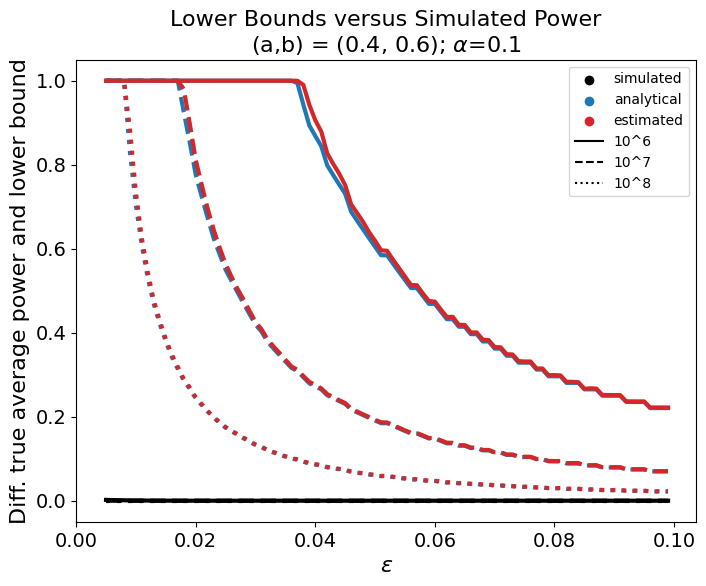

In [25]:
power_dict = pickle.load(open('data/evaluating_size_bounds.p', 'rb'))

fig, ax = plt.subplots(1,1, figsize=(8,6), sharex=True, sharey=True)

ls_dict = {budget_list[0]: '-', budget_list[1]: '--', budget_list[2]: ':'}
color_dict = {'simulated': 'k', 'analytical': 'tab:blue', 'estimated': 'tab:red'}
for budget in budget_list:
    for method in ['simulated', 'analytical', 'estimated']:
        values = np.array(list(power_dict[(a,b)][budget][method].values())).flatten()

        ax.plot(epsilon_list, values, ls=ls_dict[budget], lw=3, c=color_dict[method])

xlim, ylim = ax.get_xlim(), ax.get_ylim()
for method, color in color_dict.items():
    ax.scatter(-100, -100, c=color, label=method)

for budget, ls in ls_dict.items():
    ax.axhline(-100, c='k', label=f'10^{int(np.log10(budget))}', ls=ls)

ax.set_ylim(*ylim), ax.set_xlim(*xlim)
ax.set_title('Lower Bounds versus Simulated Power\n(a,b) = (0.4, 0.6);' + r' $\alpha$=0.1', fontsize=16)
ax.set_ylabel('Diff. true average power and lower bound', fontsize=16)
ax.set_xlabel(r'$\epsilon $', fontsize=16)
ax.set_xticks([0, 0.02, 0.04, 0.06, 0.08, 0.1])
ax.tick_params(labelsize=14)
ax.legend()

# plt.savefig('figures/estimating_power.pdf')